# Clustering and filtering pictures

In front of my house the state is building a tunnel. This project should be finished in 2019 and I like to have a cool time lapse movie of the built. Therefore I stuck a raspberry pi on a window and programmed it to take a picture every hour of the built. However a lot of pictures are taken in the night and I want to filter these from the time lapse. So, in this little project I am using unsupervised machine learning to labels the photos according to the visibility on the photos.

### importing the libraries

In [1]:
%matplotlib inline

In [2]:
import os
import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

### change the working directory

In [3]:
os.chdir('E:/Dropbox/bouwPics')

### get a list of all the pictures in the directory

In [4]:
pics = glob.glob('*.jpg')

### at the moment there are 1847 pictures

In [5]:
len(glob.glob('*.jpg'))

1851

### a typical photo during the night looks like this:

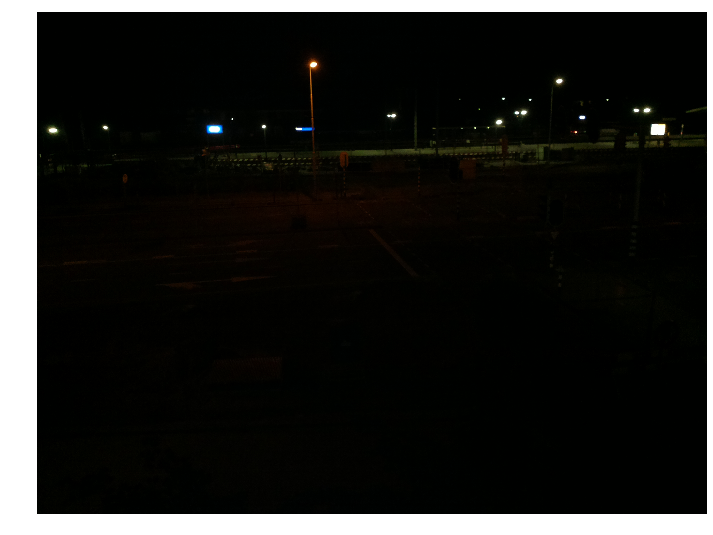

In [6]:
imNight = cv2.imread(pics[0])
fig, ax = plt.subplots(figsize=(12, 10))
plt.axis('off')
ax.imshow(cv2.cvtColor(imNight, cv2.COLOR_BGR2RGB))
plt.show()

### a during de day a typical photo looks like this:

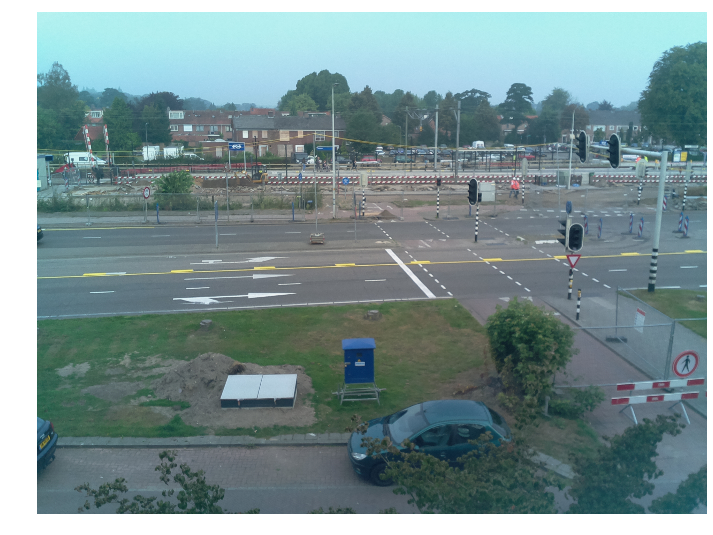

In [7]:
imDay = cv2.imread(pics[1])
fig, ax = plt.subplots(figsize=(12, 10))
plt.axis('off')
ax.imshow(cv2.cvtColor(imDay, cv2.COLOR_BGR2RGB))
plt.show()

### so, basically I want cluster all the dark photographs together
### a trick to accomplish this is to compare and cluster all the histograms of the pictures in grayscale
### a histogram is basically a count of every pixelcolor in the photograph


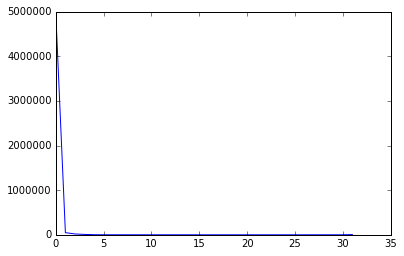

In [8]:
histNight = cv2.calcHist([imNight], [0], None, [32], [0, 256])
plt.plot(histNight)
plt.show()

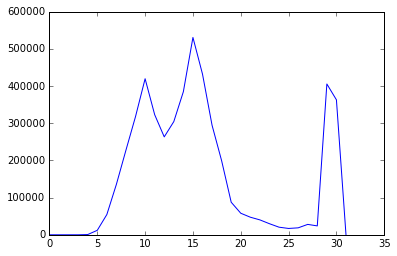

In [9]:
histDay = cv2.calcHist([imDay], [0], None, [32], [0, 256])
plt.plot(histDay)
plt.show()

### as can be seen in the figures above, a histogram during the night differs a lot from one during the day
### also the histograms can be easily converted into a vector, which are used for the clustering
### so below all the histograms from all the pictures are transformed into vectors and stacked untop of eachother to form a 1850 x 32 array

In [10]:
%%time
loop = 0
for pic in pics:
    img = cv2.imread(pic, 0)
    hist = cv2.calcHist([img], [0], None, [32], [0, 256])
    re = hist.reshape(1, 32)
    if loop > 0:
        resultArray = np.append(resultArray, re, axis=0)
    else:
        resultArray = re
    loop += 1

Wall time: 6min 58s


In [11]:
resultArray.shape

(1851L, 32L)

### we cannot plot 32 dimensions, therfore principal component analysis or PCA is used to reduce the array to two dimensions

In [12]:
reducedData = PCA(n_components=2).fit_transform(resultArray)

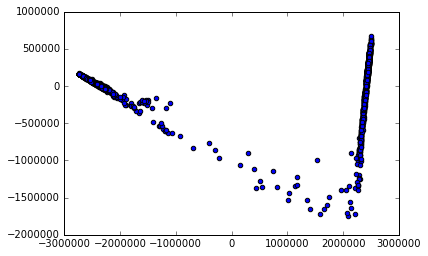

In [13]:
plt.scatter(reducedData[:,0], reducedData[:,1])
plt.show()

### we can clearly see two areas with a high density, now we can use k-means clustering to label the pictures

In [14]:
kmeans = KMeans(n_clusters=2).fit(reducedData)

In [15]:
colors = list(kmeans.labels_)
centroids = kmeans.cluster_centers_

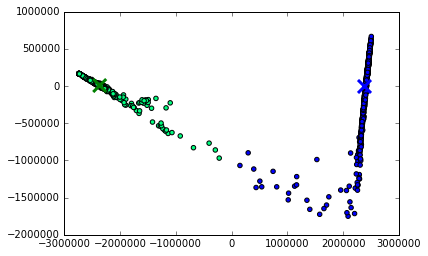

In [16]:
plt.scatter(reducedData[:,0], reducedData[:,1], cmap='winter', c=colors)
plt.scatter(centroids[:,0], centroids[:,1], c=['blue', 'green'], marker='x', s=169, linewidths=3)
plt.show()

### all the blue labels are night pictures all the green ones are taken during the day
### now we can take all the day photos and stitch them together to make a first version of the time lapse movie

In [17]:
%%time

img = cv2.imread(pics[0])
fps = 10
height, width, channels = img.shape
fourcc = cv2.cv.CV_FOURCC(*'XVID')
writer = cv2.VideoWriter('bouwPutV01.avi', fourcc, fps, (width, height))

for frame in zip(pics, kmeans.labels_):
    if frame[1] != kmeans.labels_[0]:
        img = cv2.imread(frame[0])
        writer.write(img)

writer.release()

Wall time: 9min 58s
